# Plotting maps with cartopy

---

### What does this cover?
1.  Basic map creation
2.  Opening GPCP precipitation data (netCDF file)
3.  Plot time mean and zonal average precipitation

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import xarray
import matplotlib.gridspec

import cartopy
import cartopy.util
import cartopy.io.shapereader

import pandas
import datetime

% matplotlib inline

---

# (1) Creating a cartopy map

## Cartopy works with the `fig` and `ax` syntax

* The main difference:  cartopy also requires a "crs" (coordinate reference system) class to be specified

* **Issue:**  Sometimes (often?), your data will be in a different projection than the map you want to use to display them

* **Solution:**  Create separate projection objects using what you know about your data and the map you desire to plot


## Steps to create a cartopy map:

1.  Specify the projection of the MAP and DATA separately (`map_crs`, `data_crs`)

2.  Create the `Figure` and `Axes`, and specify the `map_crs` using the `projection` keyword

3.  When you add contours or data to the map, specify `transform = data_crs`

#### See the cartopy documentation for projection (crs) options [HERE](http://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html)

Plate Carrée is the typical cylindrical equidistant projection.  
To create this:

In [2]:
data_crs = cartopy.crs.PlateCarree()
map_crs = cartopy.crs.PlateCarree()

type(map_crs)

cartopy.crs.PlateCarree

Attach the map_crs rojection to an `Axes` object:

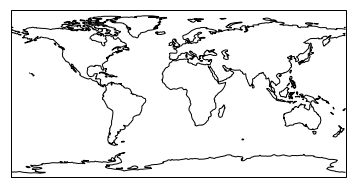

In [3]:
map_crs = cartopy.crs.PlateCarree()

fig = plt.figure()
ax = fig.add_subplot(111, projection=map_crs)
ax.coastlines()

Examples of other crs options in cartopy

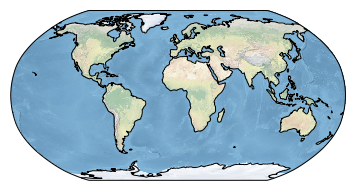

In [4]:
#map_crs = cartopy.crs.PlateCarree()
map_crs = cartopy.crs.Robinson()
#map_crs = cartopy.crs.Mollweide()
#map_crs = cartopy.crs.PlateCarree(central_longitude=180)
#map_crs = cartopy.crs.InterruptedGoodeHomolosine()

fig, ax = plt.subplots(1,1, subplot_kw={'projection':map_crs}) # specify projection as dictionary in subplot_kw
ax.coastlines()

ax.stock_img()

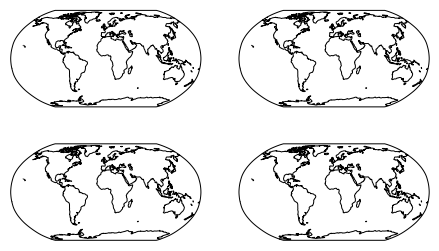

In [5]:
map_crs = cartopy.crs.Robinson()

fig, ax_array = plt.subplots(2,2,subplot_kw={'projection':map_crs})
ax1,ax2,ax3,ax4 = ax_array.flatten()

fig.set_size_inches(7.5,4.5)

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()

---

# (2) Open GPCP precipitation data

In [6]:
precip_dataset = xarray.open_dataset('../data-files/precip.mon.mean.nc')

precip_data = precip_dataset['precip'].values
precip_time = precip_dataset['time'].values
precip_lat = precip_dataset['lat'].values
precip_lon = precip_dataset['lon'].values

In [7]:
precip_time_mean = np.mean(precip_data, axis=0)

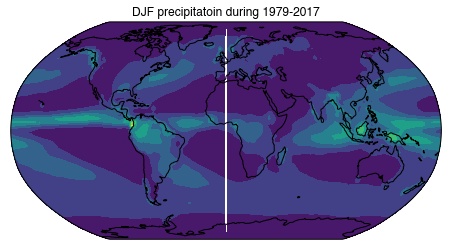

In [8]:
map_crs = cartopy.crs.Robinson()
data_crs = cartopy.crs.PlateCarree() # typical for global gridded data sets

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection=map_crs) # specify map projection
ax.coastlines()
ax.set_title('DJF precipitatoin during 1979-2017')

# ===== whenever plotting data, specify its projection
ax.contourf(precip_lon, precip_lat, precip_time_mean, \
            transform=data_crs)

# ===== uncomment below to add cyclic longitude point
#precip_cyclic, precip_lon_cyclic = cartopy.util.add_cyclic_point(precip_time_mean, precip_lon)
#ax.contourf(precip_lon_cyclic, precip_lat, precip_cyclic, \
#            transform=data_crs)

#### Add cyclic point (where it wraps from 360º to 0º longitude)

Note the colorbar below:  Easy to create one quickly, but doesn't fit the plot that well

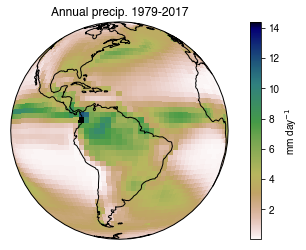

In [9]:
#map_crs = cartopy.crs.PlateCarree()
map_crs = cartopy.crs.Geostationary(central_longitude=300.)
#map_crs = cartopy.crs.Robinson()
#map_crs = cartopy.crs.InterruptedGoodeHomolosine()
data_crs = cartopy.crs.PlateCarree()

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection=map_crs)
ax.coastlines()

ax.set_title('Annual precip. 1979-2017')

precip_cyclic, precip_lon_cyclic = cartopy.util.add_cyclic_point(precip_time_mean, precip_lon)

precip_plot = ax.pcolormesh(precip_lon_cyclic, \
                            precip_lat, \
                            precip_cyclic, \
                            transform=data_crs, \
                            cmap='gist_earth_r')

cbar = plt.colorbar(precip_plot, label='mm day$^{-1}$')

# (3) Plot time mean and zonal mean next to it

#### More advanced:  change color bar, add contour lines to emphasize contours

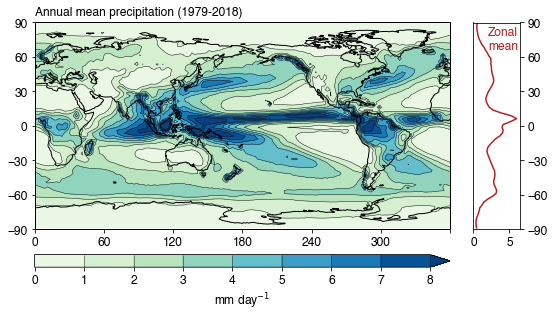

In [11]:
my_fontsize = 12

map_crs = cartopy.crs.PlateCarree(central_longitude=180.)
data_crs = cartopy.crs.PlateCarree()

fig = plt.figure(figsize=(6.5,3.5))

ax_left = fig.add_subplot(111, projection=map_crs)
ax_left.coastlines()
precip_cyclic, precip_lon_cyclic = cartopy.util.add_cyclic_point(precip_time_mean, precip_lon)
contour_plot = ax_left.contourf(precip_lon_cyclic, \
                                precip_lat, \
                                precip_cyclic, \
                                transform=data_crs, \
                                cmap='GnBu', \
                                levels=np.arange(0,8.1,1),\
                                extend='max')

contour_lines = ax_left.contour(precip_lon_cyclic, \
                                precip_lat, \
                                precip_cyclic, \
                                transform=data_crs, \
                                levels=np.arange(0,8.1,1),\
                                colors='0.1',\
                                linewidths=0.5)
ax_left.set_aspect('auto')
ax_left.tick_params(labelsize=my_fontsize)
ax_left.set_yticks([-90,-60,-30,0,30,60,90])
ax_left.set_xticks(np.arange(-180,181,60))
ax_left.set_xticklabels([str(i+180) for i in ax_left.get_xticks()[:-1]])

fig.tight_layout()
ax_pos = ax_left.get_position()

# ===== add right side
# ===== calculate zonal mean of precip
ax_right = fig.add_axes([ax_pos.x1+0.05, ax_pos.y0, 0.1, ax_pos.height], sharey=ax_left)

precip_zonal_mean = np.mean(precip_time_mean, axis=1)
ax_right.plot(precip_zonal_mean, precip_lat, c='firebrick')
ax_right.tick_params(labelsize=my_fontsize)
ax_right.yaxis.tick_right()
ax_right.set_yticks(np.arange(-90,91,30))
ax_right.set_ylim(-90,90)
ax_right.set_xlim(0,6.5)

cbar_ax = fig.add_axes([ax_pos.x0, ax_pos.y0-0.15, ax_pos.width, 0.05])
cbar = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
cbar_ax.tick_params(labelsize=my_fontsize)
cbar.set_label('mm day$^{-1}$', fontsize=my_fontsize)
cbar.add_lines(contour_lines)

ax_left.text(s='Annual mean precipitation (1979-2018)', x=0, y=1.02, \
             ha='left', va='bottom', \
             fontsize=my_fontsize, \
             transform=ax_left.transAxes)
ax_right.text(s='Zonal\nmean', x=0.95, y=0.98, \
             ha='right', va='top', \
             fontsize=my_fontsize, color='firebrick', \
             transform=ax_right.transAxes)

fig.savefig('../figures/3-maps-using-cartopy.pdf', bbox_inches='tight', transparent=True)